## Prepare Notebook

In [10]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt


az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
seed: int = sum(map(ord, "multilevel_elasticities_single_sku"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

In [12]:
market_df = pd.read_csv(("../data/multilevel_elasticities_single_sku_data.csv"))

In [13]:
obs = market_df.index.to_numpy()
price = market_df["price"].to_numpy()
log_price = market_df["log_price"].to_numpy()
quantities = market_df["quantities"].to_numpy()
log_quantities = market_df["log_quantities"].to_numpy()
median_income_idx, median_income = market_df["median_income"].factorize(sort=True)
region_idx, region = market_df["region_id"].factorize(sort=True)

https://tomicapretto.github.io/posts/2022-06-12_lkj-prior/#hierarchical-modeling-with-the-lkj-prior-in-pymc

In [14]:
# coords = {
#     "region": region,
#     "obs": obs,
#     "effect": ["intercept", "slope"],
# }

# J = 2

# with pm.Model(coords=coords) as model_cov:
#     # --- Priors ---
#     alpha_j_intercept = pm.Normal(name="alpha_j_intercept", mu=0, sigma=1)
#     beta_j_intercept = pm.Normal(name="beta_j_intercept", mu=0, sigma=1)

#     # Residual SD
#     sigma = pm.Exponential(name="sigma", lam=1 / 0.5)

#     ## ---  Begin of rstanarm approach
#     tau = pm.Gamma(name="tau", alpha=1, beta=1)
#     xi = J * tau**2
#     pi = pm.Dirichlet(name="pi", a=np.ones(J), dims="effect")
#     sigma_val = pm.Deterministic(name="b", var=sigma * pi * (xi**0.5))
#     # --  End of rstanarm approach

#     # Construct diagonal matrix of standard deviations
#     sigmas = pm.Deterministic(name="diagonal", var=pt.eye(2) * sigma_val)
#     # Triangular upper part of the correlation matrix
#     corr_triu = pm.LKJCorr(name="corr_triu", eta=2, n=2, dims="effect")
#     # Correlation matrix
#     corr = pm.Deterministic(
#         name="corr",
#         var=pt.fill_diagonal(corr_triu[np.zeros((2, 2), dtype=np.int64)], 1.0),
#     )
#     # Covariance matrix
#     cov = pt.nlinalg.matrix_dot(sigmas, corr, sigmas)
#     # Cholesky decomposition, lower triangular matrix
#     chol = pm.Deterministic(name="chol", var=pt.slinalg.cholesky(cov))

#     z_slopes = pm.Normal(name="z_slopes", mu=0, sigma=1, dims=("effect", "region"))
#     slopes = pm.Deterministic(
#         name="slopes", var=pt.dot(chol, z_slopes).T, dims=("region", "effect")
#     )

#     # --- Parametrization ---
#     alpha_j_slope = pm.Deterministic(
#         name="alpha_j_slope", var=slopes[:, 0], dims="region"
#     )

#     beta_j_slope = pm.Deterministic(
#         name="beta_j_slope", var=slopes[:, 1], dims="region"
#     )

#     alpha_j = pm.Deterministic(
#         name="alpha_j",
#         var=alpha_j_intercept + alpha_j_slope * median_income.to_numpy(),
#         dims="region",
#     )

#     beta_j = pm.Deterministic(
#         name="beta_j",
#         var=beta_j_intercept + beta_j_slope * median_income.to_numpy(),
#         dims="region",
#     )

#     alpha = pm.Deterministic(name="alpha", var=alpha_j[region_idx], dims="obs")
#     beta = pm.Deterministic(name="beta", var=beta_j[region_idx], dims="obs")

#     mu = pm.Deterministic(name="mu", var=alpha + beta * log_price, dims="obs")

#     # --- Likelihood ---
#     pm.Normal(
#         name="likelihood", mu=mu, sigma=sigma, observed=log_quantities, dims="obs"
#     )

# pm.model_to_graphviz(model=model_cov)

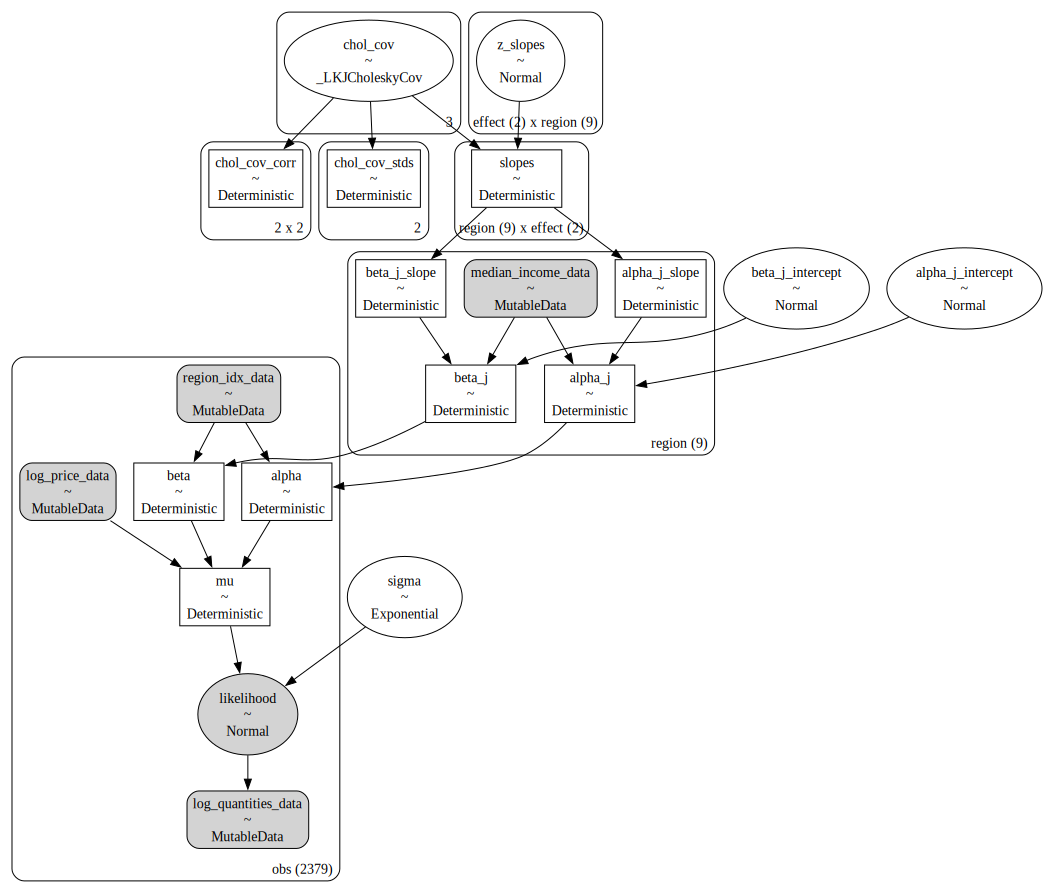

In [15]:
coords = {
    "region": region,
    "obs": obs,
    "effect": ["intercept", "slope"],
}

with pm.Model(coords=coords) as model_cov:
    # --- Data Containers ---

    region_idx_data = pm.Data(
        name="region_idx_data", value=region_idx, mutable=True, dims="obs"
    )
    median_income_data = pm.Data(
        name="median_income_data",
        value=median_income.to_numpy(),
        mutable=True,
        dims="region",
    )
    log_price_data = pm.Data(
        name="log_price_data", value=log_price, mutable=True, dims="obs"
    )
    log_quantities_data = pm.Data(
        name="log_quantities_data", value=log_quantities, mutable=True, dims="obs"
    )

    # --- Priors ---
    alpha_j_intercept = pm.Normal(name="alpha_j_intercept", mu=0, sigma=1)
    beta_j_intercept = pm.Normal(name="beta_j_intercept", mu=0, sigma=1)

    sd_dist = pm.HalfNormal.dist(sigma=0.02, shape=2)
    chol, corr, sigmas = pm.LKJCholeskyCov(name="chol_cov", eta=2, n=2, sd_dist=sd_dist)

    sigma = pm.Exponential(name="sigma", lam=1 / 0.5)

    z_slopes = pm.Normal(name="z_slopes", mu=0, sigma=1, dims=("effect", "region"))
    slopes = pm.Deterministic(
        name="slopes", var=pt.dot(chol, z_slopes).T, dims=("region", "effect")
    )

    # --- Parametrization ---
    alpha_j_slope = pm.Deterministic(
        name="alpha_j_slope", var=slopes[:, 0], dims="region"
    )

    beta_j_slope = pm.Deterministic(
        name="beta_j_slope", var=slopes[:, 1], dims="region"
    )

    alpha_j = pm.Deterministic(
        name="alpha_j",
        var=alpha_j_intercept + alpha_j_slope * median_income_data,
        dims="region",
    )

    beta_j = pm.Deterministic(
        name="beta_j",
        var=beta_j_intercept + beta_j_slope * median_income_data,
        dims="region",
    )

    alpha = pm.Deterministic(name="alpha", var=alpha_j[region_idx_data], dims="obs")
    beta = pm.Deterministic(name="beta", var=beta_j[region_idx_data], dims="obs")

    mu = pm.Deterministic(name="mu", var=alpha + beta * log_price_data, dims="obs")

    # --- Likelihood ---
    pm.Normal(
        name="likelihood", mu=mu, sigma=sigma, observed=log_quantities_data, dims="obs"
    )

pm.model_to_graphviz(model=model_cov)

In [16]:
with model_cov:
    idata_cov = pm.sample(
        target_accept=0.9,
        draws=4_000,
        chains=4,
        nuts_sampler="numpyro",
        random_seed=rng,
    )
    posterior_predictive_cov = pm.sample_posterior_predictive(
        trace=idata_cov, random_seed=rng
    )

Compiling...
Compilation time = 0:00:12.731440
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time = 0:00:23.272978
Transforming variables...
Transformation time = 0:00:02.480620
Sampling: [likelihood]
